In [1]:
import numpy as np 
import pandas as pd 
from pandas import datetime
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

#import warnings
#warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


/kaggle/input/nyse/prices-split-adjusted.csv
/kaggle/input/nyse/fundamentals.csv
/kaggle/input/nyse/prices.csv
/kaggle/input/nyse/securities.csv


It was written that prices-split-adjusted was done on the basis of prices, so we will use only 'adjusted' one. Let's load the other data and see if it is useful to predict close price.

In [2]:
prices = pd.read_csv('/kaggle/input/nyse/prices-split-adjusted.csv')
fundamentals = pd.read_csv('/kaggle/input/nyse/fundamentals.csv')
securities = pd.read_csv('/kaggle/input/nyse/securities.csv')

In [3]:
prices.head(10)

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
5,2016-01-12,WLTW,115.510002,115.550003,114.500000,116.059998,1098000.0
6,2016-01-13,WLTW,116.459999,112.849998,112.589996,117.070000,949600.0
7,2016-01-14,WLTW,113.510002,114.379997,110.050003,115.029999,785300.0
8,2016-01-15,WLTW,113.330002,112.529999,111.919998,114.879997,1093700.0
9,2016-01-19,WLTW,113.660004,110.379997,109.870003,115.870003,1523500.0


In [4]:
securities.head(10)

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877
5,AYI,Acuity Brands Inc,reports,Industrials,Electrical Components & Equipment,"Atlanta, Georgia",2016-05-03,1144215
6,ADBE,Adobe Systems Inc,reports,Information Technology,Application Software,"San Jose, California",1997-05-05,796343
7,AAP,Advance Auto Parts,reports,Consumer Discretionary,Automotive Retail,"Roanoke, Virginia",2015-07-09,1158449
8,AES,AES Corp,reports,Utilities,Independent Power Producers & Energy Traders,"Arlington, Virginia",NaN,874761
9,AET,Aetna Inc,reports,Health Care,Managed Health Care,"Hartford, Connecticut",1976-06-30,1122304


In [5]:
fundamentals.head(10)

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Current Ratio,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Earnings Before Interest and Tax,Earnings Before Tax,Effect of Exchange Rate,Equity Earnings/Loss Unconsolidated Subsidiary,Fixed Assets,Goodwill,Gross Margin,Gross Profit,Income Tax,Intangible Assets,Interest Expense,Inventory,Investments,Liabilities,Long-Term Debt,Long-Term Investments,Minority Interest,Misc. Stocks,Net Borrowings,Net Cash Flow,Net Cash Flow-Operating,Net Cash Flows-Financing,Net Cash Flows-Investing,Net Income,Net Income Adjustments,Net Income Applicable to Common Shareholders,Net Income-Cont. Operations,Net Receivables,Non-Recurring Items,Operating Income,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Financing Activities,Other Investing Activities,Other Liabilities,Other Operating Activities,Other Operating Items,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Quick Ratio,Research and Development,Retained Earnings,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-2.220000e+08,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,1.270000e+08,1.049900e+10,78.0,0.000000e+00,2.230000e+08,1.001000e+09,-1.813000e+09,-2.445000e+09,0.0,0.0,1.340200e+10,0.000000e+00,58.0,1.435600e+10,-5.690000e+08,8.690000e+08,632000000.0,5.800000e+08,3.060000e+08,4.730000e+08,7.116000e+09,0.000000e+00,0.0,0.0,-1.020000e+09,1.970000e+08,1.285000e+09,4.830000e+08,-1.571000e+09,-1.876000e+09,2.050000e+09,-1.876000e+09,-4.084000e+09,1.124000e+09,3.860000e+08,1.480000e+08,1.0,2.167000e+09,6.260000e+08,4.524000e+09,-2.980000e+09,1.509000e+09,1.100000e+07,1.514700e+10,-1.410000e+08,8.450000e+08,10.0,31.0,8.0,72.0,0.000000e+00,-9.462000e+09,0.000000e+00,1.297700e+10,1.419000e+09,3.412000e+09,2.351000e+10,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-9.300000e+07,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5.000000e+06,1.101900e+10,104.0,0.000000e+00,9.350000e+08,1.020000e+09,-1.324000e+09,-2.180000e+09,0.0,0.0,1.925900e+10,4.086000e+09,59.0,1.572400e+10,-3.460000e+08,2.311000e+09,856000000.0,1.012000e+09,-1.181000e+09,-2.350000e+08,1.535300e+10,0.000000e+00,0.0,0.0,2.208000e+09,6.600000e+08,6.750000e+08,3.799000e+09,-3.814000e+09,-1.834000e+09,1.873000e+09,-1.834000e+09,-4.489000e+09,1.560000e+09,5.590000e+08,1.399000e+09,5.0,2.299000e+09,1.465000e+09,7.385000e+09,-2.032000e+09,1.711000e+09,4.810000e+08,1.491500e+10,-5.600000e+07,8.530000e+08,8.0,80.0,7.0,96.0,0.000000e+00,-1.129600e+10,0.000000e+00,1.291300e+10,1.446000e+09,8.111000e+09,4.227800e+10,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-1.600000e+08,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7.000000e+06,1.562000e+10,88.0,0.000000e+00,8.290000e+08,1.342000e+09,4.099000e+09,3.212000e+09,0.0,0.0,2.308400e+10,4.091000e+09,63.0,2.703000e+10,3.300000e+08,2.240000e+09,887000000.0,1.004000e+09,1.799000e+09,-1.026000e+09,1.604300e+10,0.000000e+00,0.0,0.0,1.700000e+08,-1.460000e+08,3.080000e+09,-3.150000e+08,-2.911000e+09,2.882000e+09,5.420000e+08,2.882000e+09,2.882000e+09,1.771000e+09,8.000000e+08,4.249000e+09,10.0,2.060000e+09,8.980000e+08,7.059000e+09,-4.559000e+09,8.170000e+08,6.010000e+08,1.092800e+10,-5.000000e+08,1.295000e+09,8.0,159.0,7.0,80.0,0.0000

So, we have seen that 'prices' contains date, symbol, volume and prices variables like open, close, high and low. 

"Fundamentals' doesn't look very promicing in predicting price.

'Securities' contains additional info about the companies, like their sectors, full titles, headquarters, etc. Let's explore what companies are in Information Technology sector.

In [6]:
securities[securities['GICS Sector'] == 'Information Technology']['Security'].unique()

array(['Accenture plc', 'Activision Blizzard', 'Adobe Systems Inc',
       'Akamai Technologies Inc', 'Alliance Data Systems',
       'Alphabet Inc Class A', 'Alphabet Inc Class C', 'Amphenol Corp',
       'Analog Devices, Inc.', 'Apple Inc.', 'Applied Materials Inc',
       'Autodesk Inc', 'Automatic Data Processing', 'Broadcom',
       'CA, Inc.', 'Cisco Systems', 'Citrix Systems',
       'Cognizant Technology Solutions', 'Corning Inc.', 'CSRA Inc.',
       'eBay Inc.', 'Electronic Arts', 'F5 Networks', 'Facebook',
       'Fidelity National Information Services', 'First Solar Inc',
       'Fiserv Inc', 'FLIR Systems', 'Global Payments Inc',
       'Harris Corporation', 'Hewlett Packard Enterprise', 'HP Inc.',
       'Intel Corp.', 'International Business Machines', 'Intuit Inc.',
       'Juniper Networks', 'KLA-Tencor Corp.', 'Lam Research',
       'Linear Technology Corp.', 'Mastercard Inc.',
       'Microchip Technology', 'Micron Technology', 'Microsoft Corp.',
       'Motorola Sol

In [7]:
#let's have a look at how things went for 'Visa Inc.'
securities[securities['Security']=='Visa Inc.'] #to get ticker symbol, it's "V"
visa = prices[prices['symbol']=="V"] #making a subset of prices as a new set for Visa Inc
visa = visa.drop('symbol', 1)
visa

,date,open,close,low,high,volume
680,2010-01-04,22.000000,22.035000,21.865000,22.192499,20180000.0
1148,2010-01-05,21.825001,21.782499,21.500000,21.882500,25833600.0
1616,2010-01-06,21.752501,21.490000,21.475001,21.770000,16254000.0
2084,2010-01-07,21.492500,21.690001,21.387501,21.750000,27841200.0
2552,2010-01-08,21.705000,21.750000,21.557501,21.847500,11907200.0
...,...,...,...,...,...,...
849222,2016-12-23,78.080002,78.150002,77.900002,78.480003,6189700.0
849722,2016-12-27,78.269997,78.349998,78.230003,78.849998,3768500.0
850222,2016-12-28,78.400002,78.300003,77.970001,78.650002,7412700.0
850722,2016-12-29,78.489998,78.330002,78.300003,78.839996,6016300.0


We got 1762 rows and 7 columns, let's explore them.

In [8]:
import pandas_profiling
profile = pandas_profiling.ProfileReport(visa)
profile

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From profile report we can conclude that there are no missing values, prices have range from 16 to 84 and there is a strong correlation between prices variables. Another important note is that date column is categorical, not a datetime object. We need to fix this.

In [9]:
visa['date'] = pd.to_datetime(visa['date'])
visa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1762 entries, 680 to 851222
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1762 non-null   datetime64[ns]
 1   open    1762 non-null   float64       
 2   close   1762 non-null   float64       
 3   low     1762 non-null   float64       
 4   high    1762 non-null   float64       
 5   volume  1762 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 96.4 KB


In [10]:
px.line(visa, x = 'date', y = ['open', 'close'])

In [11]:
px.line(visa, x = 'date', y = ['low', 'high'])

In [12]:
px.line(visa, x = 'date', y = ['volume'])

General trend shows increasing of prices year by year while the volume is decreasing (with some outliers).

In [13]:
df1 = deepcopy(visa) #for Neural Prophet, contains 'date'
df = deepcopy(visa) #for LSTM, dropping 'date' as a column, using as index
df.set_index("date", inplace=True)

In [14]:
#scaling values in order to look at all of them on one graph
for feature in ['open', 'close', 'high', 'low', 'volume']:
    sc = MinMaxScaler()
    visa[feature] = sc.fit_transform(visa[feature].values.reshape(-1,1))
    
#looking at all numerical features at once    
px.line(visa, x = 'date', y = ['open', 'close', 'high', 'low', 'volume'])

In [15]:
len(df) # 1762
test_point = 50 #We want to predict for the last 50 values
test_index = int(len(df) - test_point) #1712
train = df.iloc[:test_index,1:2] #to get the first 1712 values of the index and vwap
test = df.iloc[test_index:,1:2] #to get the last 50 values of the index and vwap
train #to look at output (under cut)

,close
date,
2010-01-04,22.035000
2010-01-05,21.782499
2010-01-06,21.490000
2010-01-07,21.690001
2010-01-08,21.750000
...,...
2016-10-13,81.870003
2016-10-14,82.449997
2016-10-17,82.150002


In [16]:
scaler = MinMaxScaler() #scaler for df dataset
scaler.fit(train) #fit the scaler on train set
MinMaxScaler(copy=True, feature_range=(0, 1))
scaled_train = scaler.transform(train) #transform on train and test sets separately
scaled_test = scaler.transform(test)

In [17]:
length = 49 #for input shape
batch_size = 1
n_features=1 #target variable

#creating generators for fitting a model
generator = TimeseriesGenerator(scaled_train,scaled_train, length=length,batch_size=batch_size)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=batch_size)

#very simple Sequantial model
model = Sequential()
model.add(LSTM(50,input_shape=(length,n_features)))
model.add(Dense(1))

#adam optimizer, loss = mean squared error
model.compile(optimizer = 'adam',loss='mse',metrics=['accuracy'])

model.fit_generator(generator,epochs=20,validation_data=validation_generator)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/20
1663/1663 [==============================] - 45s 26ms/step - loss: 0.0176 - accuracy: 0.0013 - val_loss: 5.7141e-04 - val_accuracy: 0.0000e+00
Epoch 2/20
1663/1663 [==============================] - 42s 25ms/step - loss: 4.9845e-04 - accuracy: 8.1293e-04 - val_loss: 1.5513e-04 - val_accuracy: 0.0000e+00
Epoch 3/20
1663/1663 [==============================] - 41s 25ms/step - loss: 3.4788e-04 - accuracy: 0.0013 - val_loss: 9.8007e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
1663/1663 [==============================] - 40s 24ms/step - loss: 3.8513e-04 - accuracy: 0.0016 - val_loss: 5.2571e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
1663/1663 [==============================] - 41s 25ms/step - loss: 2.8925e-04 - accuracy: 0.0027 - val_loss: 1.4412e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
1663/1663 [==============================] - 39s 24ms/step - loss: 2.8080e-04 - accuracy: 6.1796e-04 - val_loss: 6.8923e-05 - val_accuracy: 0.0000e+00
Epoch 7/20
1663/1663 [==========================

In [18]:
test_predictions = [] #variable for predictions
first_eval_batch = scaled_train[-length:] #(49,1)
current_batch = first_eval_batch.reshape(1,length,n_features) #reshape to (1,49,1)

#using a loop to predict: predict the first value,add the resut to test predictions 
#and replace the value in current batch. To make next predictions on the previous predictions
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],
                              [[current_pred]],axis = 1)

<AxesSubplot:xlabel='date'>

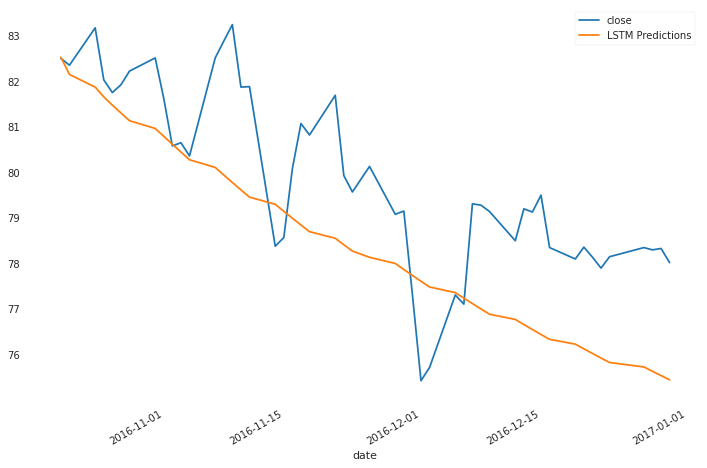

In [19]:
#inversing predictions from scaled to normal
true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM Predictions'] = true_predictions #add predictions to test set
test.plot(figsize=(12,8)) #plotting

In [20]:
df1 = df1[["date", "close"]]
df1.rename(columns={"date": "ds", "close": "y"}, inplace=True)
df_train = df1.iloc[:test_index] #splitting data for not scaled train set
#we already have test set as test

In [21]:
!pip install git+https://github.com/ourownstory/neural_prophet.git  
!pip install livelossplot    #it will allow us to use plot_live_live parameter 
#in the train function to get live training and validation plots.

  Cloning https://github.com/ourownstory/neural_prophet.git to /tmp/pip-req-build-t6pfzuc4
  Running command git clone -q https://github.com/ourownstory/neural_prophet.git /tmp/pip-req-build-t6pfzuc4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


  Created wheel for neuralprophet: filename=neuralprophet-0.2.8-py3-none-any.whl size=57891 sha256=3d41a46af5104799522710ff6a2e3d7c217d87da19ab7a29ce934e5fd59c5a3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-c6m7j2v1/wheels/bc/d0/dd/f2b1133865669ed9b544f6f1ff9155aedf57c9dbfc72ce211e
Successfully built neuralprophet
     |████████████████████████████████| 428 kB 851 kB/s eta 0:00:01
  Attempting uninstall: tornado
    Found existing installation: tornado 5.0.2
    Uninstalling tornado-5.0.2:
      Successfully uninstalled tornado-5.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.1.0 which is incompatible.
autogluon-core 0.1.0b20210210 requires numpy==1.19, but you have numpy 1.19.5 which is incompatible.


In [22]:
from neuralprophet import NeuralProphet

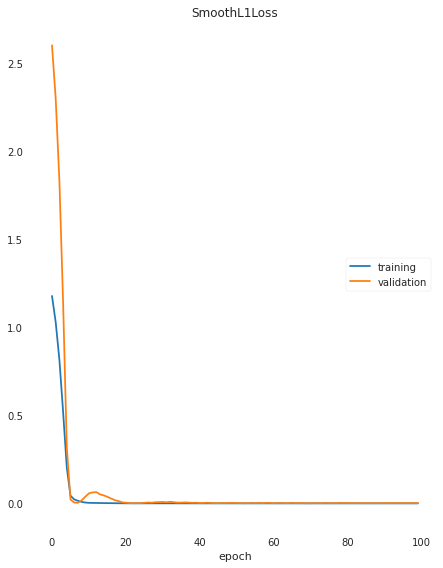

Epoch[100/100]: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s, SmoothL1Loss=0.00108, MAE=1.75, MSE=5.38, RegLoss=0.000443, MAE_val=2.88, MSE_val=13.8, SmoothL1Loss_val=0.00277]


In [27]:
model = NeuralProphet(n_changepoints=10,
                      trend_reg=0.1,
                      yearly_seasonality=False,
                      weekly_seasonality=False,
                      daily_seasonality=True)
metrics = model.fit(df_train, validate_each_epoch=True, 
                    valid_p=0.2, freq='D', 
                    plot_live_loss=True, 
                    epochs=100)

In [28]:
future = model.make_future_dataframe(df_train, 
                periods=50) #predict for 50 days
forecast = model.predict(future)

<AxesSubplot:xlabel='date'>

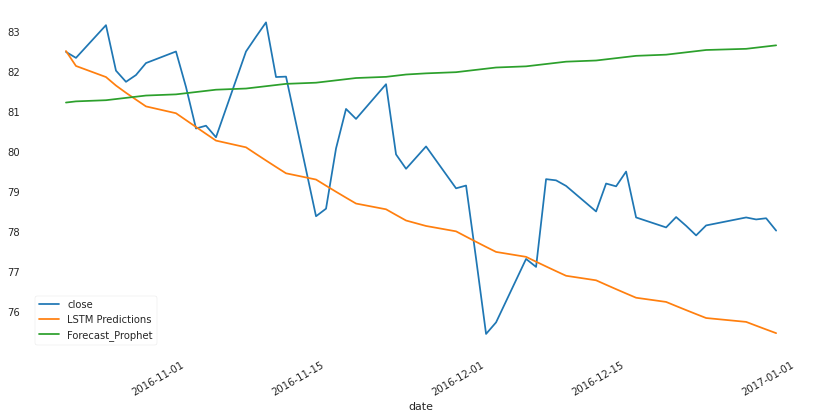

In [29]:
test["Forecast_Prophet"] = forecast.yhat1.values
test.plot(figsize=(14, 7)) #plotting

In [30]:
from sklearn.metrics import mean_absolute_error
print("Results for the test set:")
print("MAE of LSTM:", mean_absolute_error(test.close, 
                            test['LSTM Predictions']))
print("MAE of Neural Prophet:", 
      mean_absolute_error(test.close, test.Forecast_Prophet))

Results for the test set:
MAE of LSTM: 1.6322228965885563
MAE of Neural Prophet with regressors: 2.6032151106152357


We can look at MAE scores and admit that LSTM does a better job, but here it is even more obvious if we look on the graph. LSTM shows a nice generalization for 50 days. However, if we needed prediction for 20 days, Neural Prophet could be a better choice.